# **Water Management and Forecasting**
### **Project Backgroung**
The arid climate of several Algerian regions and the water-stressed region of Bhopal, effective water management and forecasting are crucial. This project aims to harness the power of machine learning to address the unique water resource challenges faced by both regions. By creating an open-source solution, we aim to empower Algeria and Bhopal to make informed decisions, optimize resource allocation, and build resilient water infrastructure for a sustainable future.
### **Project Goals**
**Develop a Comprehensive Open-Source Water Management and Forecasting System:** Create a user-friendly platform tailored to the specific needs of Algeria and Bhopal, integrating machine learning algorithms for precise water forecasting and efficient water resource management.

- **Enhance Water Resource Utilization:** Improve the sustainable use of water resources in both regions by providing accurate forecasts and real-time monitoring.
- **Capacity Building:** Empower local stakeholders in Algeria and Bhopal with the knowledge and tools necessary to make well-informed decisions about water management.
- **Community Engagement:** Foster collaboration among local government agencies, NGOs, and the research community to collectively address water-related challenges in both regions.

# **Summary of Data Processing**
* GFS, GLDAS, OpenMetro and population datasets were merged into one

* A new feature 'water_availability' is created and use it as a target variable
* 'water_availability' is calculated deducting the demand from the water supply
* The water supply is calculated the water capacity plus daily water volume change
* The details of calculation is explained in the Feature Engineering section

* The final dataset is collected from 2015 April 1 to December June 30 with the below dates missing due to data absence:</br>
{
'2015-04-10', '2015-04-11', '2015-04-12', '2015-04-13', '2015-04-14', '2015-04-15', '2015-04-16', '2015-04-17', '2015-04-18', '2015-04-19', '2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31', '2020-12-31', '2021-12-31', '2022-12-31'
}

* 'Qsb_tavg' were dropped

* The dataset was split into train and test datasets: train --> 2015 to 2021, test --> 2022 & 2023
* Save them in csv
* x_train_bhopal.csv: 2435 rows, 29 columns
* x_test_bhopal.csv: 545 rows, 29 columns 
* y_train_bhopal.csv
* y_test_bhopal.csv

**Data Source:**
###### * https://developers.google.com/earth-engine/datasets/catalog/NOAA_GFS0P25
###### * https://developers.google.com/earth-engine/datasets/catalog/NASA_GLDAS_V022_CLSM_G025_DA1D


# **Import Modules**

In [108]:
#### Import the libraries needed
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import os
import glob

import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import statsmodels.api as sm

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')
%matplotlib notebook
%matplotlib inline

# **Set Environment**

In [109]:
import plotly.io as pio
pio.renderers.default = "vscode"

In [110]:
# Set up directory
working_directory = Path.cwd()
src = working_directory.parents[1]
# data directory
raw_data_directory = src / 'data' / 'raw'
processed_data_directory = src / 'data' / 'processed'
final_data_directory = src / 'data' / 'final'

In [111]:
# Set pd.options to add slide bars
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [112]:
# Set default title color
plt.style.use('fivethirtyeight')

# set default plt figure size
plt.rcParams["figure.figsize"] = [10, 5]
# suptitle
plt.rcParams["figure.titlesize"] = 22
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams['text.color'] = '#333333'
# title
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.titlelocation"] = "left"
plt.rcParams['axes.titlecolor'] = '#333333'
# label
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['axes.labelcolor'] = '#333333'
# spines
plt.rcParams["axes.spines.bottom"] = True
plt.rcParams["axes.spines.left"] = True
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
# tick
plt.rcParams['xtick.color'] = "#333333"
plt.rcParams['ytick.color'] = "#333333"

## **Load OpenMeteo Dataset**

In [280]:
file = os.path.join(raw_data_directory, 'open-meteo-36.73N3.07E116m_Algiers.csv')
open_df_1 = pd.read_csv(file)
open_df_1['date'] = pd.to_datetime(open_df_1['time'], format='%m/%d/%Y')

In [281]:
open_df_1 = open_df_1[['date', 'precipitation_sum (mm)']]
open_df_1.head()

,date,precipitation_sum (mm)
0,2015-04-01,0.0
1,2015-04-02,0.0
2,2015-04-03,0.0
3,2015-04-04,0.0
4,2015-04-05,0.0


In [125]:
open_df_1.tail()


,date,precipitation_sum (mm)
1731,2019-12-27,0.0
1732,2019-12-28,0.0
1733,2019-12-29,0.1
1734,2019-12-30,1.9
1735,2019-12-31,0.3


In [282]:
file = os.path.join(raw_data_directory, 'open-meteo-36.45N3.41E587m_2020-2023.csv')
open_df_2 = pd.read_csv(file)
open_df_2['date'] = pd.to_datetime(open_df_2['time'], format='%m/%d/%Y')

In [283]:
open_df_2 = open_df_2[['date', 'precipitation_sum (mm)']]
open_df_2.head()

,date,precipitation_sum (mm)
0,2020-01-01,0.0
1,2020-01-02,0.0
2,2020-01-03,0.0
3,2020-01-04,0.2
4,2020-01-05,0.0


In [284]:
open_df_2.tail()

,date,precipitation_sum (mm)
1272,2023-06-26,0.0
1273,2023-06-27,0.0
1274,2023-06-28,0.0
1275,2023-06-29,0.0
1276,2023-06-30,0.0


In [229]:
open_df = pd.concat([open_df_1, open_df_2])
open_df.head()

,date,precipitation_sum (mm)
0,2015-04-01,0.0
1,2015-04-02,0.0
2,2015-04-03,0.0
3,2015-04-04,0.0
4,2015-04-05,0.0


In [285]:
open_df.tail()

,date,precipitation_sum (mm)
1272,2023-06-26,0.0
1273,2023-06-27,0.0
1274,2023-06-28,0.0
1275,2023-06-29,0.0
1276,2023-06-30,0.0


In [286]:
open_df.shape

(3013, 2)

## **Load all GFS Datasets and Merge into gfs_df**

* **temperature_2m_above_ground (°C)**: Temperature 2m above ground
* **specific_humidity_2m_above_ground (%)**: Specific humidity 2m above ground
* **relative_humidity_2m_above_ground (%)**: Relative humidity 2m above ground
* **u_component_of_wind_10m_above_ground (m/s)**: U component of wind 10m above ground
* **v_component_of_wind_10m_above_ground (m/s)**: V component of wind 10m above ground
* **total_precipitation_surface (kg/m^2)**: Cumulative precipitation at surface for the previous 1-6 hours, depending on the value of the "forecast_hours" property according to the formula ((F - 1) % 6) + 1 (and only for assets with forecast_hours > 0)
* **precipitable_water_entire_atmosphere (kg/m^2)**: Precipitable water for entire atmosphere
* **total_cloud_cover_entire_atmosphere (%)**: Total cloud cover for entire atmosphere (only for assets with forecast_hours > 0)
* **downward_shortwave_radiation_flux (W/m^2)**: Downward shortwave radiation flux (only for assets with forecast_hours > 0)

In [410]:
# save result in list -> all_filenames
algiers_filenames = [file_name for file_name in glob.glob(str(raw_data_directory) + "/*.csv") if os.path.basename(file_name).startswith('GFS_Algiers')]

# Combine all files in the list
gfs_df = pd.concat([pd.read_csv(f) for f in algiers_filenames])

In [411]:
gfs_df['date'] = pd.to_datetime(gfs_df['date'], format="%y-%m-%d")
gfs_df.sort_values('date', inplace=True)

In [412]:
gfs_df.head()

,date,city,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface
0,2015-04-01,Algeirs,11.984259,0.007020,79.653691,-1.008622,-1.247756,11.792043,0.000000
1,2015-04-02,Algeirs,12.426162,0.006639,73.369087,-0.882894,-0.674852,10.580860,0.000000
2,2015-04-03,Algeirs,13.183237,0.007103,73.648926,-0.554821,-0.975509,13.224449,0.000000
3,2015-04-04,Algeirs,12.117507,0.006628,74.249417,-0.762048,-1.315288,11.899657,0.000000
4,2015-04-05,Algeirs,11.775280,0.006604,75.414558,-1.970064,-1.730378,13.397951,0.015292


In [413]:
gfs_df.tail()

,date,city,temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface
359,2023-12-26,Algeirs,13.287490,0.005679,58.733457,0.291778,0.983468,14.734136,0.016570
360,2023-12-27,Algeirs,12.757580,0.005465,58.555935,0.487006,0.898728,14.393022,0.093632
361,2023-12-28,Algeirs,12.152473,0.005281,58.577695,0.609848,0.694102,12.946366,0.130209
362,2023-12-29,Algeirs,11.642398,0.005398,62.122674,0.407405,0.827354,13.102902,0.330744
363,2023-12-30,Algeirs,10.874042,0.004803,58.500969,0.662139,1.058809,11.660767,0.197368


In [414]:
gfs_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,3178,2019-08-20 14:19:33.568281856,2015-04-01 00:00:00,2017-06-15 06:00:00,2019-08-20 12:00:00,2021-10-24 18:00:00,2023-12-30 00:00:00,NaN
temperature_2m_above_ground,3178.0,576430272495755.125,6.27538,14.115582,18.527273,24.377049,1831895405991448832.0,32495537663798356.0
specific_humidity_2m_above_ground,3178.0,0.018798,0.004119,0.006384,0.00819,0.01035,32.467991,0.575795
relative_humidity_2m_above_ground,3178.0,60.782006,25.021849,55.669993,62.098087,67.408081,86.133422,9.355736
u_component_of_wind_10m_above_ground,3178.0,0.038384,-6.751671,-0.810067,-0.152947,0.721083,263.863495,4.977968
v_component_of_wind_10m_above_ground,3178.0,-0.35227,-7.417929,-1.14603,-0.5132,0.345038,7.260548,1.1139
precipitable_water_entire_atmosphere,3178.0,19.854502,7.904516,14.903047,19.257818,24.173752,40.842689,6.012432
total_precipitation_surface,3178.0,0.269621,0.0,0.024207,0.126327,0.346459,6.370371,0.417657


In [415]:
gfs_df.shape

(3178, 9)

In [372]:
gfs_df.isna().sum()

date                                    0
city                                    0
temperature_2m_above_ground             0
specific_humidity_2m_above_ground       0
relative_humidity_2m_above_ground       0
u_component_of_wind_10m_above_ground    0
v_component_of_wind_10m_above_ground    0
precipitable_water_entire_atmosphere    0
total_precipitation_surface             0
dtype: int64

In [373]:
gfs_df.duplicated().sum()

0

In [424]:
# The mean of 'temperature_2m_above_ground' is 576430272495755.125. There should be erronulous value(s)
avg_temp_may_2018 = gfs_df[(gfs_df['date'] >= '2018-01-01') & (gfs_df['date'] <= '2018-01-31')]['temperature_2m_above_ground'].mean()
gfs_df.loc[gfs_df['temperature_2m_above_ground'] >= 576430272495755.125, 'temperature_2m_above_ground'] = avg_temp_may_2018

## **Load GLDAS Dataset**

* **ACond_tavg (m/s)**: 	Aerodynamic conductance
* **AvgSurfT_tavg (K)**: 	Average surface skin temperature
* **CanopInt_tavg (kg/m^2)**: 	Plant canopy surface water
* **ECanop_tavg (kg/m^2/s)**: 	Canopy water evaporation
* **ESoil_tavg (kg/m^2/s)**: 	Direct evaporation from bare soil
* **Evap_tavg (kg/m^2/s)**: 	Evapotranspiration                 
* **GWS_tavg (mm)**: 	Ground water storage
* **Lwnet_tavg (W/m^2)**: 	Net long-wave radiation flux
* **Qg_tavg (W/m^2)**: 	Heat flux
* **Qh_tavg (W/m^2)**: 	Sensible heat net flux
* **Qle_tavg (W/m^2)**: 	Latent heat net flux
* **Qs_tavg (kg/m^2/s)**: 	Storm surface runoff                 
* **SnowT_tavg (K)**: 	Snow Surface temperature
* **SoilMoist_P_tavg (kg/m^2)**: 	Profile Soil moisture
* **SoilMoist_RZ_tavg (kg/m^2)**: 	Root Zone Soil moisture
* **SoilMoist_S_tavg (kg/m^2)**: 	Surface Soil moisture
* **Swnet_tavg (W/m^2)**: 	Net short wave radiation flux
* **TVeg_tavg (kg/m^2/s)**: 	Transpiration               
* **TWS_tavg (mm)**: 	Terrestrial water storage

In [427]:
# Convert the 'date' columns to datetime data type
file = os.path.join(raw_data_directory, 'GLDAS_Algiers_2010_2023.csv')
gldas_df = pd.read_csv(file)
gldas_df['date'] = pd.to_datetime(gldas_df['date'], format='%y-%m-%d')

In [428]:
# Drop the columns that have all 0 values
gldas_df.drop('Qsb_tavg', axis=1, inplace=True)

In [429]:
gldas_df.head()

,date,city,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,EvapSnow_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qsm_tavg,Qs_tavg,SnowDepth_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,SWE_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg
0,2010-01-01,Algeirs,0.082993,286.687545,0.017668,6.106833e-06,0.000015,0.0,0.000022,655.390076,-54.342835,-11.430156,-25.461993,53.940294,0.0,1.845114e-06,0.0,286.687545,889.618471,234.228496,5.058322,0.0,71.386511,0.000001,889.636240
1,2010-01-02,Algeirs,0.033933,286.336357,0.013592,2.220712e-06,0.000008,0.0,0.000012,655.785311,-49.610188,-11.082603,4.840276,29.741976,0.0,1.130567e-07,0.0,286.336357,889.981110,234.195734,4.770398,0.0,73.100717,0.000002,889.994643
2,2010-01-03,Algeirs,0.017356,285.944329,0.002365,2.569379e-08,0.000007,0.0,0.000009,656.091261,-65.548131,-5.941080,13.228863,22.964956,0.0,0.000000e+00,0.0,285.944329,889.438253,233.346994,4.729158,0.0,95.803675,0.000003,889.440639
3,2010-01-04,Algeirs,0.019539,288.113141,0.002453,1.132388e-07,0.000011,0.0,0.000014,656.280887,-53.330799,5.021038,-4.210028,34.835989,0.0,1.852611e-08,0.0,288.113141,888.647073,232.366208,4.674092,0.0,88.986264,0.000003,888.649558
4,2010-01-05,Algeirs,0.059151,287.461861,0.020187,4.647594e-06,0.000013,0.0,0.000020,656.415591,-42.786895,-4.772042,-14.750718,49.051028,0.0,1.905058e-06,0.0,287.461861,889.658359,233.242742,5.058011,0.0,72.314331,0.000002,889.678507


In [430]:
gldas_df.tail()

,date,city,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,EvapSnow_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qsm_tavg,Qs_tavg,SnowDepth_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,SWE_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg
4924,2023-06-26,Algeirs,0.023664,299.978419,0.000117,6.915491e-10,0.000016,0.0,0.000018,615.131064,-81.450209,3.828643,130.415590,45.406270,0.0,0.000000e+00,0.0,299.978419,817.442170,202.311043,3.753905,0.0,261.102911,0.000002,817.442231
4925,2023-06-27,Algeirs,0.028536,301.610507,0.000080,-9.519874e-11,0.000019,0.0,0.000021,614.274391,-73.203237,11.163433,120.194116,51.941447,0.0,0.000000e+00,0.0,301.610507,815.839382,201.564931,3.695763,0.0,256.507065,0.000002,815.839407
4926,2023-06-28,Algeirs,0.026261,303.132496,0.000303,7.858855e-09,0.000022,0.0,0.000024,613.397566,-83.005846,13.250753,99.281847,59.831149,0.0,1.326372e-11,0.0,303.132496,813.961735,200.564191,3.596900,0.0,255.369908,0.000002,813.962042
4927,2023-06-29,Algeirs,0.018966,302.776263,0.000469,1.130979e-08,0.000017,0.0,0.000018,612.482079,-73.062095,7.882219,126.276936,44.975309,0.0,1.991875e-11,0.0,302.776263,812.211206,199.729207,3.643714,0.0,252.197913,0.000002,812.211777
4928,2023-06-30,Algeirs,0.025112,302.268787,0.000391,5.191073e-09,0.000014,0.0,0.000015,611.545862,-61.037151,4.940081,143.560292,37.948923,0.0,3.829902e-11,0.0,302.268787,810.868841,199.322989,3.703943,0.0,247.484794,0.000001,810.869255


## **Load Algiers-population-2023-11-22.csv**

* **date** 	
* **Population**	 
* **Annual Change**

In [431]:
# Convert the 'date' columns to datetime data type
file = os.path.join(raw_data_directory, 'Algiers-population-2023-11-22.csv')
population_df = pd.read_csv(file)
population_df['date'] = pd.to_datetime(population_df['date'], format='%Y-%m-%d')
population_df.head()

,date,Population,Annual Change
0,1950-12-31,516000,NaN
1,1951-12-31,534000,3.49
2,1952-12-31,552000,3.37
3,1953-12-31,570000,3.26
4,1954-12-31,589000,3.33


In [432]:
population_df.tail()

,date,Population,Annual Change
81,2031-12-31,3312000,1.50
82,2032-12-31,3359000,1.42
83,2033-12-31,3406000,1.40
84,2034-12-31,3451000,1.32
85,2035-12-31,3496000,1.30


## **Descriptive Statistics and Basic Information**

In [433]:
open_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,3013,2019-05-16 00:00:00,2015-04-01 00:00:00,2017-04-23 00:00:00,2019-05-16 00:00:00,2021-06-07 00:00:00,2023-06-30 00:00:00,NaN
precipitation_sum (mm),3013.0,1.429937,0.0,0.0,0.0,0.6,45.3,3.962096


In [434]:
gfs_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,3178,2019-08-20 14:19:33.568281856,2015-04-01 00:00:00,2017-06-15 06:00:00,2019-08-20 12:00:00,2021-10-24 18:00:00,2023-12-30 00:00:00,NaN
temperature_2m_above_ground,3178.0,19.298235,6.27538,14.114262,18.518889,24.364343,33.406556,5.926064
specific_humidity_2m_above_ground,3178.0,0.018798,0.004119,0.006384,0.00819,0.01035,32.467991,0.575795
relative_humidity_2m_above_ground,3178.0,60.782006,25.021849,55.669993,62.098087,67.408081,86.133422,9.355736
u_component_of_wind_10m_above_ground,3178.0,0.038384,-6.751671,-0.810067,-0.152947,0.721083,263.863495,4.977968
v_component_of_wind_10m_above_ground,3178.0,-0.35227,-7.417929,-1.14603,-0.5132,0.345038,7.260548,1.1139
precipitable_water_entire_atmosphere,3178.0,19.854502,7.904516,14.903047,19.257818,24.173752,40.842689,6.012432
total_precipitation_surface,3178.0,0.269621,0.0,0.024207,0.126327,0.346459,6.370371,0.417657


In [435]:
gldas_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,4929,2016-09-30 00:00:00,2010-01-01 00:00:00,2013-05-17 00:00:00,2016-09-30 00:00:00,2020-02-14 00:00:00,2023-06-30 00:00:00,NaN
ACond_tavg,4929.0,0.027671,0.006431,0.01908,0.024459,0.032703,0.096481,0.012665
AvgSurfT_tavg,4929.0,293.28093,276.692419,287.425346,292.474395,299.394434,309.055053,6.873357
CanopInt_tavg,4929.0,0.013565,0.000014,0.000769,0.00375,0.016614,0.123301,0.021231
ECanop_tavg,4929.0,0.000002,-0.0,0.0,0.0,0.000002,0.000011,0.000002
ESoil_tavg,4929.0,0.000013,0.000003,0.000009,0.000013,0.000016,0.000035,0.000005
EvapSnow_tavg,4929.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
Evap_tavg,4929.0,0.000018,0.000004,0.000012,0.000017,0.000022,0.000064,0.000008
GWS_tavg,4929.0,632.167487,541.784971,591.645508,630.782553,666.914663,736.32852,47.100998
Lwnet_tavg,4929.0,-53.238216,-98.741738,-68.730825,-56.175925,-39.663934,16.565141,20.233416


In [436]:
population_df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,86,1993-07-01 05:51:37.674418560,1950-12-31 00:00:00,1972-03-31 12:00:00,1993-07-01 12:00:00,2014-09-30 18:00:00,2035-12-31 00:00:00,NaN
Population,86.0,1936383.72093,516000.0,1334000.0,1883500.0,2551000.0,3496000.0,819776.772608
Annual Change,85.0,2.288941,0.56,1.29,1.68,3.29,7.02,1.618541


In [437]:
# Check the shape of the datasets
print("Shape of datasets")
print("OpenMeteo", open_df.shape)
print("GFS: ", gfs_df.shape)
print("GLADAS: ", gldas_df.shape)
print("Population: ", population_df.shape)

Shape of datasets
OpenMeteo (3013, 2)
GFS:  (3178, 9)
GLADAS:  (4929, 25)
Population:  (86, 3)


In [438]:
# Check the null values
print("Number of null values")
print("OpenMeteo", open_df.isna().sum().sum())
print("GFS: ", gfs_df.isna().sum().sum())
print("GLADAS: ", gldas_df.isna().sum().sum())
print("Population: ", population_df.isna().sum().sum())

Number of null values
OpenMeteo 0
GFS:  0
GLADAS:  0
Population:  1


In [439]:
# Print date range
print("OpenMeteo: ", open_df['date'].min(), open_df['date'].max())
print("GFS: ", gfs_df['date'].min(), gfs_df['date'].max())
print("GLADS: ", gldas_df['date'].min(), gldas_df['date'].max())
print("Population: ", population_df['date'].min(), population_df['date'].max())

OpenMeteo:  2015-04-01 00:00:00 2023-06-30 00:00:00
GFS:  2015-04-01 00:00:00 2023-12-30 00:00:00
GLADS:  2010-01-01 00:00:00 2023-06-30 00:00:00
Population:  1950-12-31 00:00:00 2035-12-31 00:00:00


### Check missing dates

In [440]:
open_df.sort_values('date', inplace=True)
print("Date Range in OpenMeteo")
print(open_df['date'].min())
print(open_df['date'].max())

Date Range in OpenMeteo
2015-04-01 00:00:00
2023-06-30 00:00:00


In [441]:
# Check missing dates
start_date = open_df['date'].min()
end_date = open_df['date'].max()
dates = set(d.strftime("%Y-%m-%d") for d in pd.date_range(start_date, end_date))

df_date_set = set(d.strftime("%Y-%m-%d") for d in open_df['date'])

missing_dates = dates.difference(df_date_set)

print(f"OpenMeteo has {len(missing_dates)} missing days")
missing_dates

OpenMeteo has 0 missing days


set()

In [442]:
# Check missing dates
start_date = gfs_df['date'].min()
end_date = gfs_df['date'].max()
dates = set(d.strftime("%Y-%m-%d") for d in pd.date_range(start_date, end_date))

df_date_set = set(d.strftime("%Y-%m-%d") for d in gfs_df['date'])

missing_dates = dates.difference(df_date_set)

print(f"GFS has {len(missing_dates)} missing days")
missing_dates

GFS has 18 missing days


{'2015-04-10',
 '2015-04-11',
 '2015-04-12',
 '2015-04-13',
 '2015-04-14',
 '2015-04-15',
 '2015-04-16',
 '2015-04-17',
 '2015-04-18',
 '2015-04-19',
 '2015-12-31',
 '2016-12-31',
 '2017-12-31',
 '2018-12-31',
 '2019-12-31',
 '2020-12-31',
 '2021-12-31',
 '2022-12-31'}

In [443]:
gfs_df.sort_values('date', inplace=True)
print("Date Range in GLDAS")
print(gldas_df['date'].min())
print(gldas_df['date'].max())

Date Range in GLDAS
2010-01-01 00:00:00
2023-06-30 00:00:00


In [444]:
# Check missing dates
start_date = gldas_df['date'].min()
end_date = gldas_df['date'].max()
dates = set(d.strftime("%Y-%m-%d") for d in pd.date_range(start_date, end_date))
df_date_set = set(d.strftime("%Y-%m-%d") for d in gldas_df['date'])

missing_dates = dates.difference(df_date_set)

print(f"GLDAS has {len(missing_dates)} missing days")
missing_dates

GLDAS has 0 missing days


set()

In [445]:
# Check columns
gfs_num_cols = gfs_df.select_dtypes(include=[np.number]).columns
print(f"Numerical Columns: {gfs_num_cols}")
print()

gfs_cat_cols = gfs_df.select_dtypes(exclude=[np.number]).columns
print(f"Categorical Columns: {gfs_cat_cols}")

Numerical Columns: Index(['temperature_2m_above_ground', 'specific_humidity_2m_above_ground',
       'relative_humidity_2m_above_ground',
       'u_component_of_wind_10m_above_ground',
       'v_component_of_wind_10m_above_ground',
       'precipitable_water_entire_atmosphere', 'total_precipitation_surface'],
      dtype='object')

Categorical Columns: Index(['date', 'city'], dtype='object')


In [446]:
# Check columns
gldas_num_cols = gldas_df.select_dtypes(include=[np.number]).columns
print(f"Numerical Columns: {gldas_num_cols}")
print()
gldas_cat_cols = gldas_df.select_dtypes(exclude=[np.number]).columns
print(f"Categorical Columns: {gldas_cat_cols}")

Numerical Columns: Index(['ACond_tavg', 'AvgSurfT_tavg', 'CanopInt_tavg', 'ECanop_tavg',
       'ESoil_tavg', 'EvapSnow_tavg', 'Evap_tavg', 'GWS_tavg', 'Lwnet_tavg',
       'Qg_tavg', 'Qh_tavg', 'Qle_tavg', 'Qsm_tavg', 'Qs_tavg',
       'SnowDepth_tavg', 'SnowT_tavg', 'SoilMoist_P_tavg', 'SoilMoist_RZ_tavg',
       'SoilMoist_S_tavg', 'SWE_tavg', 'Swnet_tavg', 'TVeg_tavg', 'TWS_tavg'],
      dtype='object')

Categorical Columns: Index(['date', 'city'], dtype='object')


In [447]:
# Check columns
population_num_cols = population_df.select_dtypes(include=[np.number]).columns
print(f"Numerical Columns: {population_num_cols}")
print()
population_cat_cols = population_df.select_dtypes(exclude=[np.number]).columns
print(f"Categorical Columns: {population_cat_cols}")

Numerical Columns: Index([' Population', ' Annual Change'], dtype='object')

Categorical Columns: Index(['date'], dtype='object')


# **Merge OpenMeteo, GLDAS and GFS Datasets**
* GFS_Algiers_xxxx.csv where xxxx are from 2014 to 2023
* GLDAS_Bhopal_2010_2023.csv

In [448]:
# Merge gldas_df and gfs_df
gldas_df.drop('city', axis=1, inplace=True)
gfs_df.drop('city', axis=1, inplace=True)
df = pd.merge(gfs_df, gldas_df, on='date', how='inner')

In [449]:
df = pd.merge(open_df, df, on='date', how='inner' )
df.head(3)

,date,precipitation_sum (mm),temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,EvapSnow_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qsm_tavg,Qs_tavg,SnowDepth_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,SWE_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg
0,2015-04-01,0.0,11.984259,0.007020,79.653691,-1.008622,-1.247756,11.792043,0.0,0.023497,290.359024,0.000295,1.045537e-09,0.000013,0.0,0.000026,697.313574,-74.658654,1.094868,76.821687,64.901560,0.0,0.000000e+00,0.0,290.359024,935.768881,238.455282,4.762528,0.0,217.475818,0.000013,935.769155
1,2015-04-02,0.0,12.426162,0.006639,73.369087,-0.882894,-0.674852,10.580860,0.0,0.032284,288.967108,0.003869,2.495082e-07,0.000012,0.0,0.000022,696.656447,-72.014443,-5.066211,93.003513,54.667225,0.0,2.099938e-10,0.0,288.967108,933.417838,236.761384,4.734760,0.0,214.612400,0.000010,933.421715
2,2015-04-03,0.0,13.183237,0.007103,73.648926,-0.554821,-0.975509,13.224449,0.0,0.021108,289.621761,0.000882,1.892229e-09,0.000012,0.0,0.000023,695.900341,-71.404626,4.399809,84.064386,55.659225,0.0,0.000000e+00,0.0,289.621761,931.212514,235.312021,4.710264,0.0,215.533733,0.000011,931.213284


In [450]:
df.tail(3)

,date,precipitation_sum (mm),temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,EvapSnow_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qsm_tavg,Qs_tavg,SnowDepth_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,SWE_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg
2992,2023-06-28,0.0,27.585945,0.010687,47.948198,-0.340813,-1.308779,24.040315,0.016438,0.026261,303.132496,0.000303,7.858855e-09,0.000022,0.0,0.000024,613.397566,-83.005846,13.250753,99.281847,59.831149,0.0,1.326372e-11,0.0,303.132496,813.961735,200.564191,3.596900,0.0,255.369908,0.000002,813.962042
2993,2023-06-29,0.0,27.541890,0.010552,47.376700,-0.257126,-1.335453,23.216075,0.010434,0.018966,302.776263,0.000469,1.130979e-08,0.000017,0.0,0.000018,612.482079,-73.062095,7.882219,126.276936,44.975309,0.0,1.991875e-11,0.0,302.776263,812.211206,199.729207,3.643714,0.0,252.197913,0.000002,812.211777
2994,2023-06-30,0.0,27.549470,0.010776,47.866210,-0.303356,-1.393334,24.093027,0.003688,0.025112,302.268787,0.000391,5.191073e-09,0.000014,0.0,0.000015,611.545862,-61.037151,4.940081,143.560292,37.948923,0.0,3.829902e-11,0.0,302.268787,810.868841,199.322989,3.703943,0.0,247.484794,0.000001,810.869255


## **Add population column**
* Add population from Bhopal-population-2023-11-22.csv

In [451]:
# Add the 'population' column to df
population_df['year'] = population_df['date'].dt.year
df['year'] = df['date'].dt.year
df['population'] = [population_df[population_df['year'] == y][' Population'].values[0] for y in df['year']]

In [452]:
df.head(3)

,date,precipitation_sum (mm),temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,EvapSnow_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qsm_tavg,Qs_tavg,SnowDepth_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,SWE_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg,year,population
0,2015-04-01,0.0,11.984259,0.007020,79.653691,-1.008622,-1.247756,11.792043,0.0,0.023497,290.359024,0.000295,1.045537e-09,0.000013,0.0,0.000026,697.313574,-74.658654,1.094868,76.821687,64.901560,0.0,0.000000e+00,0.0,290.359024,935.768881,238.455282,4.762528,0.0,217.475818,0.000013,935.769155,2015,2592000
1,2015-04-02,0.0,12.426162,0.006639,73.369087,-0.882894,-0.674852,10.580860,0.0,0.032284,288.967108,0.003869,2.495082e-07,0.000012,0.0,0.000022,696.656447,-72.014443,-5.066211,93.003513,54.667225,0.0,2.099938e-10,0.0,288.967108,933.417838,236.761384,4.734760,0.0,214.612400,0.000010,933.421715,2015,2592000
2,2015-04-03,0.0,13.183237,0.007103,73.648926,-0.554821,-0.975509,13.224449,0.0,0.021108,289.621761,0.000882,1.892229e-09,0.000012,0.0,0.000023,695.900341,-71.404626,4.399809,84.064386,55.659225,0.0,0.000000e+00,0.0,289.621761,931.212514,235.312021,4.710264,0.0,215.533733,0.000011,931.213284,2015,2592000


# **Descriptive Statistics**

In [453]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2995 entries, 0 to 2994
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   date                                  2995 non-null   datetime64[ns]
 1   precipitation_sum (mm)                2995 non-null   float64       
 2   temperature_2m_above_ground           2995 non-null   float64       
 3   specific_humidity_2m_above_ground     2995 non-null   float64       
 4   relative_humidity_2m_above_ground     2995 non-null   float64       
 5   u_component_of_wind_10m_above_ground  2995 non-null   float64       
 6   v_component_of_wind_10m_above_ground  2995 non-null   float64       
 7   precipitable_water_entire_atmosphere  2995 non-null   float64       
 8   total_precipitation_surface           2995 non-null   float64       
 9   ACond_tavg                            2995 non-null   float64       
 10  

In [454]:
df.describe(include='all').T

,count,mean,min,25%,50%,75%,max,std
date,2995,2019-05-20 20:36:08.414023424,2015-04-01 00:00:00,2017-04-30 12:00:00,2019-05-21 00:00:00,2021-06-09 12:00:00,2023-06-30 00:00:00,NaN
precipitation_sum (mm),2995.0,1.438331,0.0,0.0,0.0,0.65,45.3,3.972497
temperature_2m_above_ground,2995.0,19.168962,6.27538,14.111838,18.391352,24.137384,33.406556,5.846036
specific_humidity_2m_above_ground,2995.0,0.019427,0.004119,0.0064,0.008131,0.010374,32.467991,0.593125
relative_humidity_2m_above_ground,2995.0,61.204259,25.021849,56.352543,62.489995,67.706579,86.133422,9.15053
u_component_of_wind_10m_above_ground,2995.0,0.022292,-6.751671,-0.887877,-0.182643,0.699948,263.863495,5.124687
v_component_of_wind_10m_above_ground,2995.0,-0.358446,-7.417929,-1.16519,-0.521717,0.342551,7.260548,1.131295
precipitable_water_entire_atmosphere,2995.0,19.809982,7.904516,14.839904,19.134466,24.176662,40.842689,6.058899
total_precipitation_surface,2995.0,0.27335,0.0,0.024365,0.127236,0.352018,6.370371,0.424622
ACond_tavg,2995.0,0.026682,0.006431,0.018853,0.02416,0.031194,0.091502,0.011705


In [455]:
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
print(f"First date: {df['date'].min()}")
print(f"Last date: {df['date'].max()}")

First date: 2015-04-01 00:00:00
Last date: 2023-06-30 00:00:00


In [456]:
# Check missing dates
start_date = df['date'].min()
end_date = df['date'].max()
dates = set(d.strftime("%Y-%m-%d") for d in pd.date_range(start_date, end_date))

df_date_set = set(d.strftime("%Y-%m-%d") for d in df['date'])

missing_dates = dates.difference(df_date_set)

print(f"Dataset has {len(missing_dates)} missing days")
missing_dates

Dataset has 18 missing days


{'2015-04-10',
 '2015-04-11',
 '2015-04-12',
 '2015-04-13',
 '2015-04-14',
 '2015-04-15',
 '2015-04-16',
 '2015-04-17',
 '2015-04-18',
 '2015-04-19',
 '2015-12-31',
 '2016-12-31',
 '2017-12-31',
 '2018-12-31',
 '2019-12-31',
 '2020-12-31',
 '2021-12-31',
 '2022-12-31'}

# **Feature Engineering**
### **Daily Water Supply**
* The city of Algiers depends on three main water resources for its water supply: surface water, groundwater, and desalinated water. The current production capacity is only around 700 MLD
* 30 percent of general supply is lost as it is distributed through Algeria's aging, leaking water transportation infrastructure. 
* Therefore, 70% of the production capacity, **490 MLD** is the water supply to Algiers.

### **Daily Water Demand**
* Algeria's daily water demand per capita: **200 (l/c/d)**

### **Daily Water Availability**
* Daily water availability is calculated adding Water Supply and Delta S
* Delta S is the daily change of water volume which is calculated: $$\Delta S = Precipitation - Evapotranspiration - Runoff$$

**Major Dams and Surface Area**
|Name|Surface Area (Km²)|
| --- | --- |
|Taksebt|20|
|Beni amarane| 0.015|
|Koudiat Acerdoune| 15|
|Keddara|5.2|
|Ghrib|30|
|Boukourdane |5.4|
|Bouroumi|0.015|
|**Total**|**75.63**|

**Constant**
* Daily Water Supply = 490 (MLD)
* Daily Water Demand = 200 (LCD)
* Surface Area of Water Source = 75.63 (Km²)
**Variables**
* precipitation_sum (mm)
* Evap_tavg (kg/m^2/s)
* Qs_tavg (kg/m^2/s)

* Our target variable, 'water_availability' has been calculated as follows:
$$Precipitation (MLD) = Dam Area (km^{2}) * precipitation_sum (mm)$$ 
$$Evapotranspiration (MLD) = (Dam Area (km^{2}) * 10^{6}) * Evap_tavg (kg/m^2/s) * 86400 * 10^{-6}$$
$$Runoff (MLD) = (Dam Area (km^{2}) * 10^{6}) * Qs_tavg (kg/m^2/s) * 86400 * 10^{-6}$$
$$\Delta S = Precipitation - Evapotranspiration - Runoff$$
$$Daily Water Volume (MLD) = Water Supply + \Delta S$$
$$Daily Water Demand in Algeria (MLD) = Daily Water Demand (LCD) * Population * 10^{-6}$$
$$Daily Water Availability in Algeria (MLD) = Daily Water Volume (MLD) - Daily Water Demand in Algeria (MLD)$$

**Conversion**
$$1 (mm) = 10^{-6} (km)$$
$$1 (km^{2}) = 10^{6} (m^{2})$$
$$1 (km^{3}) = 10^{6} (ML)$$
$$1 (m^{3}) = 10^{3} (liters)$$
$$1 (kg) of water = 1 (liters) of water$$
$$1 (ML) = 10^{6} (liters)$$
$$1 (day) = 60 (sec) * 60 (min) * 24 (hour) = 86400 (sec)$$

###### **Reference**: Simulation of Water needs balance for the next 50 years under urban sprawl: case study from Algeria</br>
###### **URL**: https://ymerdigital.com/uploads/YMER%20230123.pdf</br>
###### **Reference**: Algeria: A Desert Nation Fighting to Maintain Water Supplies
###### **URL**: https://worldview.stratfor.com/article/algeria-desert-nation-fighting-maintain-water-supplies

In [457]:
# Set constants
water_supply= 490
# Set the total lake and reservoir area to lake_reservoir_area
total_dam_area = 75.63
# Water demand'
daily_water_demand_lcd = 200
# A day in second
day_in_sec = 86400

# Calculate daily water volume in liter
precipitation_mld = total_dam_area * df['precipitation_sum (mm)']
evapotranspiration_mld = total_dam_area * 10**6 * (df['Evap_tavg'] * day_in_sec * 10**(-6))
runoff_mld = total_dam_area * 10**6 * (df['Qs_tavg'] * day_in_sec * 10**(-6))
delta = precipitation_mld - evapotranspiration_mld - runoff_mld
daily_water_volume = water_supply + delta
daily_water_demand_mld = daily_water_demand_lcd * df['population'] * 10**(-6)
df['water_availability'] = daily_water_volume - daily_water_demand_mld

In [458]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
date,2995,2019-05-20 20:36:08.414023424,2015-04-01 00:00:00,2017-04-30 12:00:00,2019-05-21 00:00:00,2021-06-09 12:00:00,2023-06-30 00:00:00,NaN
precipitation_sum (mm),2995.0,1.438331,0.0,0.0,0.0,0.65,45.3,3.972497
temperature_2m_above_ground,2995.0,19.168962,6.27538,14.111838,18.391352,24.137384,33.406556,5.846036
specific_humidity_2m_above_ground,2995.0,0.019427,0.004119,0.0064,0.008131,0.010374,32.467991,0.593125
relative_humidity_2m_above_ground,2995.0,61.204259,25.021849,56.352543,62.489995,67.706579,86.133422,9.15053
u_component_of_wind_10m_above_ground,2995.0,0.022292,-6.751671,-0.887877,-0.182643,0.699948,263.863495,5.124687
v_component_of_wind_10m_above_ground,2995.0,-0.358446,-7.417929,-1.16519,-0.521717,0.342551,7.260548,1.131295
precipitable_water_entire_atmosphere,2995.0,19.809982,7.904516,14.839904,19.134466,24.176662,40.842689,6.058899
total_precipitation_surface,2995.0,0.27335,0.0,0.024365,0.127236,0.352018,6.370371,0.424622
ACond_tavg,2995.0,0.026682,0.006431,0.018853,0.02416,0.031194,0.091502,0.011705


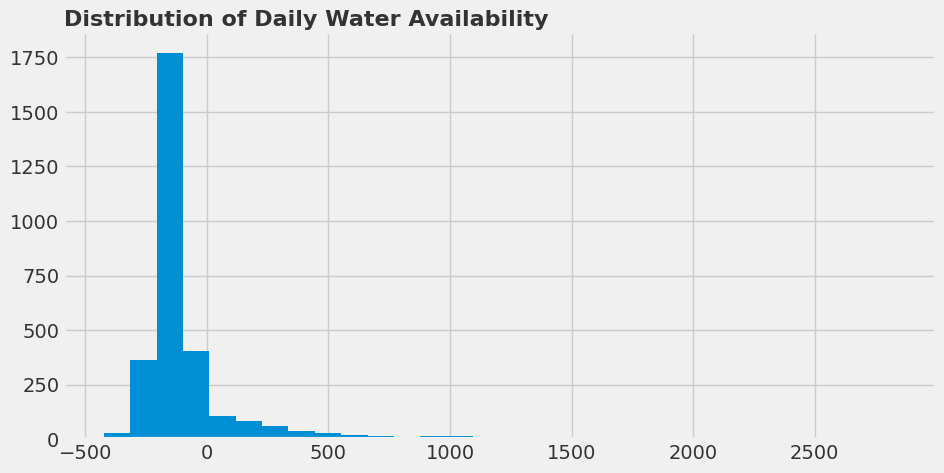

In [459]:
plt.title("Distribution of Daily Water Availability")
df['water_availability'].hist(bins=30);

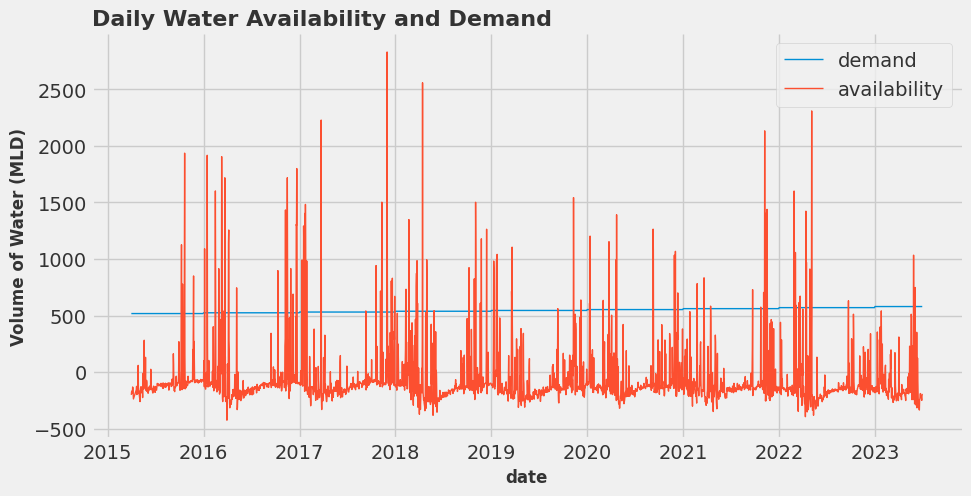

In [475]:
plt.title("Daily Water Availability and Demand")
sns.lineplot(x=df['date'], y=daily_water_demand_mld, linewidth=1, label='demand')
sns.lineplot(x=df['date'], y=df['water_availability'], linewidth=1, label='availability')
plt.ylabel("Volume of Water (MLD)")
plt.legend();

In [476]:
# Save the dataframe
file = os.path.join(final_data_directory, "GLDAS_GFS_population_Algeria_2015_2023_final.csv")
df.to_csv(file, index=False, encoding='utf-8-sig')

# **Split the data into the training and test datasets**

In [ ]:
# Drop 'year' and 'population'
df.drop(['year', 'population'], axis=1, inplace=True)

In [468]:
# Split df into training --> from 2015 to 2021 and test datasets --> 2022 and 2023
training_df = df[df['date'] <= '2021-12-31']
test_df = df[df['date'] >= '2022-01-01']

In [469]:
training_df.head()

,date,precipitation_sum (mm),temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,EvapSnow_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qsm_tavg,Qs_tavg,SnowDepth_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,SWE_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg,water_availability
0,2015-04-01,0.0,11.984259,0.007020,79.653691,-1.008622,-1.247756,11.792043,0.000000,0.023497,290.359024,0.000295,1.045537e-09,0.000013,0.0,0.000026,697.313574,-74.658654,1.094868,76.821687,64.901560,0.0,0.000000e+00,0.0,290.359024,935.768881,238.455282,4.762528,0.0,217.475818,0.000013,935.769155,-200.341947
1,2015-04-02,0.0,12.426162,0.006639,73.369087,-0.882894,-0.674852,10.580860,0.000000,0.032284,288.967108,0.003869,2.495082e-07,0.000012,0.0,0.000022,696.656447,-72.014443,-5.066211,93.003513,54.667225,0.0,2.099938e-10,0.0,288.967108,933.417838,236.761384,4.734760,0.0,214.612400,0.000010,933.421715,-173.229781
2,2015-04-03,0.0,13.183237,0.007103,73.648926,-0.554821,-0.975509,13.224449,0.000000,0.021108,289.621761,0.000882,1.892229e-09,0.000012,0.0,0.000023,695.900341,-71.404626,4.399809,84.064386,55.659225,0.0,0.000000e+00,0.0,289.621761,931.212514,235.312021,4.710264,0.0,215.533733,0.000011,931.213284,-175.856488
3,2015-04-04,0.0,12.117507,0.006628,74.249417,-0.762048,-1.315288,11.899657,0.000000,0.022526,289.779312,0.005318,4.072546e-07,0.000011,0.0,0.000021,695.060537,-65.248931,0.365141,85.535857,51.311719,0.0,1.797587e-08,0.0,289.779312,929.087080,234.026542,4.696759,0.0,202.458474,0.000009,929.092368,-164.456208
4,2015-04-05,0.0,11.775280,0.006604,75.414558,-1.970064,-1.730378,13.397951,0.015292,0.027819,289.759368,0.004718,1.334104e-07,0.000013,0.0,0.000024,694.151078,-77.620184,2.372418,83.209995,59.583113,0.0,1.837402e-11,0.0,289.759368,926.925510,232.774424,4.638155,0.0,222.788846,0.000011,926.930220,-186.252044


In [470]:
test_df.head()

,date,precipitation_sum (mm),temperature_2m_above_ground,specific_humidity_2m_above_ground,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,precipitable_water_entire_atmosphere,total_precipitation_surface,ACond_tavg,AvgSurfT_tavg,CanopInt_tavg,ECanop_tavg,ESoil_tavg,EvapSnow_tavg,Evap_tavg,GWS_tavg,Lwnet_tavg,Qg_tavg,Qh_tavg,Qle_tavg,Qsm_tavg,Qs_tavg,SnowDepth_tavg,SnowT_tavg,SoilMoist_P_tavg,SoilMoist_RZ_tavg,SoilMoist_S_tavg,SWE_tavg,Swnet_tavg,TVeg_tavg,TWS_tavg,water_availability
2450,2022-01-01,0.0,14.362410,0.005930,59.793684,0.649728,-0.129626,11.859802,0.450822,0.009450,286.788900,0.000782,-5.246332e-09,0.000006,0.0,0.000008,670.350511,-56.954232,-5.204900,21.730757,19.526346,0.0,0.000000e+00,0.0,286.788900,899.052530,228.701979,4.636154,0.0,93.006431,0.000002,899.053248,-132.530627
2451,2022-01-02,0.0,13.754120,0.005732,59.988725,1.456428,-0.439457,11.737146,0.411741,0.008960,286.541410,0.000911,4.679698e-09,0.000006,0.0,0.000008,669.621073,-56.545044,-4.560012,23.188950,20.101474,0.0,0.000000e+00,0.0,286.541410,898.045329,228.424234,4.628034,0.0,95.277539,0.000002,898.046216,-134.054294
2452,2022-01-03,0.0,13.007181,0.005865,64.340447,1.428484,-0.409314,13.172519,0.663236,0.008998,286.935664,0.001460,1.009109e-08,0.000006,0.0,0.000009,668.889502,-56.657229,-2.750546,19.718157,21.520434,0.0,3.831248e-12,0.0,286.935664,897.024039,228.134524,4.619723,0.0,95.147285,0.000002,897.025475,-137.813533
2453,2022-01-04,0.0,12.400852,0.005519,62.652419,2.115176,-0.380763,12.382598,0.260890,0.017794,287.612572,0.001026,8.520166e-09,0.000012,0.0,0.000016,668.158258,-78.418359,2.031848,-18.328602,39.270307,0.0,0.000000e+00,0.0,287.612572,895.738426,227.580171,4.549587,0.0,101.400477,0.000004,895.739475,-184.837768
2454,2022-01-05,0.4,11.651835,0.005592,65.912025,1.913405,-0.568244,13.392617,0.313993,0.065906,286.317625,0.013199,3.851126e-06,0.000015,0.0,0.000020,667.386450,-43.499395,-10.925153,-10.330051,49.241328,0.0,4.364737e-07,0.0,286.317625,894.526057,227.139445,4.626612,0.0,71.475149,0.000001,894.539133,-183.853833


In [471]:
print("Shape of training dataset: ", training_df.shape)
print("Shape of test dataset: ", test_df.shape)

Shape of training dataset:  (2450, 33)
Shape of test dataset:  (545, 33)


In [472]:
# Save the dataframe
file = os.path.join(final_data_directory, "train_algiers.csv")
training_df.to_csv(file, index=False, encoding='utf-8-sig')

file = os.path.join(final_data_directory, "test_algiers.csv")
test_df.to_csv(file, index=False, encoding='utf-8-sig')